In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
# variable information 
print(abalone.variables) 

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [3]:
# Combine features and targets into one DataFrame
df = pd.concat([X, y], axis=1)

# Display the DataFrame
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


 # ENCODEUR AVEC 0,1,2

In [13]:
dataset = df
# Transformer les espèces en valeurs numériques
dataset.loc[dataset.Sex == 'M', 'Sex'] = 0
dataset.loc[dataset.Sex == 'F', 'Sex'] = 1
dataset.loc[dataset.Sex == 'I', 'Sex'] = 2

# Conversion en type numérique
dataset['Sex'] = pd.to_numeric(dataset['Sex'])
dataset

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,14
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,6
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,8
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,9
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,6
...,...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,10
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,9
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,8
4175,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,9


In [12]:

dataset['Rings'] -= dataset['Rings'].min()

train_X, test_X, train_y, test_y = train_test_split(
    dataset[dataset.columns[0:8]].values,
    dataset.Rings.values,
    test_size=0.2
)
# Conversion en tensors PyTorch
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

# Construction de la classe pour le NLP
class Net(nn.Module):
    def __init__(self,units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, units)  # Nombre d'unités variable
        self.fc2 = nn.Linear(units, units)  # Nombre d'unités variable
        self.fc3 = nn.Linear(units, 29)  # Couche de sortie pour correspondre au nombre de classes
        self.softmax = nn.Softmax(dim=1) # 28 sorties

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)
        return X
    
# Fonction pour entraîner et évaluer le modèle
def train_and_evaluate(units):
    net = Net(units)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    Perte = []

    # Entraîner le réseau
    for epoch in range(5000):
        optimizer.zero_grad()
        out = net(train_X)
        loss = criterion(out, train_y)
        loss.backward()
        optimizer.step()

    #    if epoch % 1000 == 0:
    #        print(f'Units: {units}, Epoch: {epoch}, Loss: {loss.item()}')
        Perte.append(loss.item())

    # Évaluer le réseau
    with torch.no_grad():
        predict_out = net(test_X)
        _, predict_y = torch.max(predict_out, 1)

    accuracy = accuracy_score(test_y, predict_y)
    return accuracy,predict_y,Perte

# Tester différentes configurations
best_accuracy = 0
best_units = 0
predict_y = []
loss = []
for units in range(50, 501, 50):
    accuracy, predict_y, loss = train_and_evaluate(units)
    print(f'Unités: {units}, Précision: {accuracy}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_units = units

print(f'Meilleur nombre d\'unités: {best_units}, Meilleure précision: {best_accuracy}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3341x7 and 8x50)

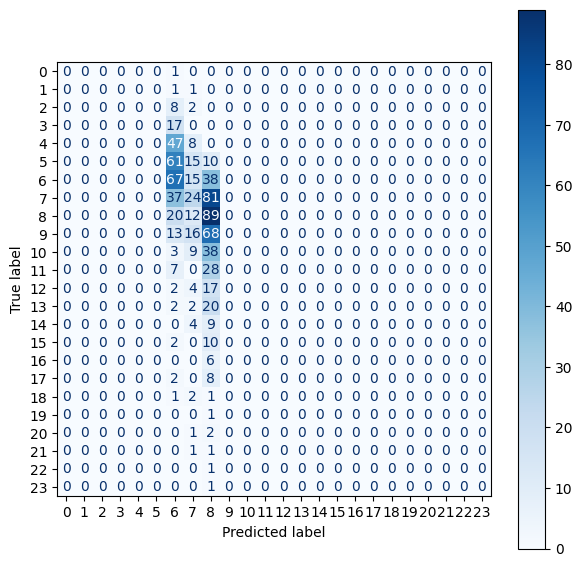

In [6]:
# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(test_y,predict_y)
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figsize as needed
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

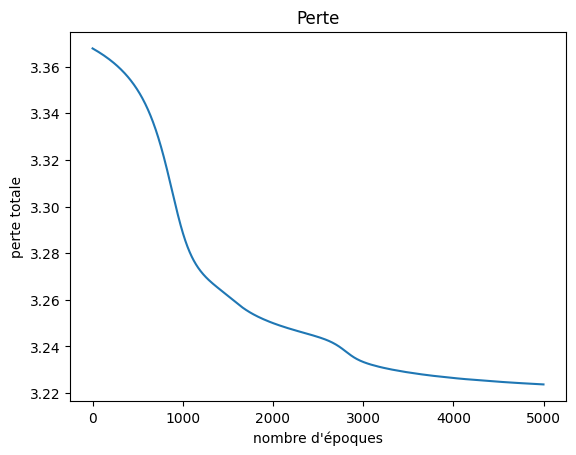

In [7]:
plt.plot(loss)
plt.xlabel("nombre d'époques")
plt.ylabel("perte totale")
plt.title("Perte")
plt.show()

# ENCODEUR AVEC CREATION DE COLONNES

In [14]:
# Transformer les espèces en valeurs numériques
df_1 = df[df.columns[0:7]]
df_1['Sex_1'] = np.where(df_1['Sex']=='M',1,-1)
df_1['Sex_2'] = np.where(df_1['Sex']=='F',1,-1)

# Conversion en type numérique
df_1['Sex_1'] = pd.to_numeric(df_1['Sex_1'])
df_1['Sex_2'] = pd.to_numeric(df_1['Sex_2'])

df_1 = df_1[df_1.columns[1:9]]
df_1 = pd.concat([df_1, y], axis=1)
df_1

/var/folders/cw/lr079v3x42v2cctvdpqcgzgw0000gn/T/ipykernel_33695/1154688084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Sex_1'] = np.where(df_1['Sex']=='M',1,-1)


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Sex_1,Sex_2,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,-1,-1,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,-1,-1,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,-1,-1,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,-1,-1,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,-1,-1,7
...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,-1,-1,11
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,-1,-1,10
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,-1,-1,9
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,-1,-1,10


In [15]:
dataset = df_1
dataset['Rings'] -= dataset['Rings'].min()

train_X, test_X, train_y, test_y = train_test_split(
    dataset[dataset.columns[0:8]].values,
    dataset.Rings.values,
    test_size=0.2
)

# Conversion en tensors PyTorch
train_X = torch.tensor(train_X, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
test_y = torch.tensor(test_y, dtype=torch.long)

# Construction de la classe pour le NLP
class Net(nn.Module):
    def __init__(self,units):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, units)  # Nombre d'unités variable
        self.fc2 = nn.Linear(units, units)  # Nombre d'unités variable
        self.fc3 = nn.Linear(units, 29)  # Couche de sortie pour correspondre au nombre de classes
        self.softmax = nn.Softmax(dim=1) # 28 sorties

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)
        return X
    
# Fonction pour entraîner et évaluer le modèle
def train_and_evaluate(units):
    net = Net(units)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    Perte = []

    # Entraîner le réseau
    for epoch in range(5000):
        optimizer.zero_grad()
        out = net(train_X)
        loss = criterion(out, train_y)
        loss.backward()
        optimizer.step()

    #    if epoch % 1000 == 0:
    #        print(f'Units: {units}, Epoch: {epoch}, Loss: {loss.item()}')
        Perte.append(loss.item())

    # Évaluer le réseau
    with torch.no_grad():
        predict_out = net(test_X)
        _, predict_y = torch.max(predict_out, 1)

    accuracy = accuracy_score(test_y, predict_y)
    return accuracy,predict_y,Perte

# Tester différentes configurations
best_accuracy = 0
best_units = 0
predict_y = []
loss = []
for units in range(50, 501, 50):
    accuracy, predict_y, loss = train_and_evaluate(units)
    print(f'Unités: {units}, Précision: {accuracy}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_units = units

print(f'Meilleur nombre d\'unités: {best_units}, Meilleure précision: {best_accuracy}')

Unités: 50, Précision: 0.16626794258373206
Unités: 100, Précision: 0.1686602870813397
Unités: 150, Précision: 0.16626794258373206
Unités: 200, Précision: 0.1590909090909091
Unités: 250, Précision: 0.16985645933014354
Unités: 300, Précision: 0.16626794258373206
Unités: 350, Précision: 0.16626794258373206
Unités: 400, Précision: 0.16626794258373206
Unités: 450, Précision: 0.1686602870813397
Unités: 500, Précision: 0.1686602870813397
Meilleur nombre d'unités: 250, Meilleure précision: 0.16985645933014354


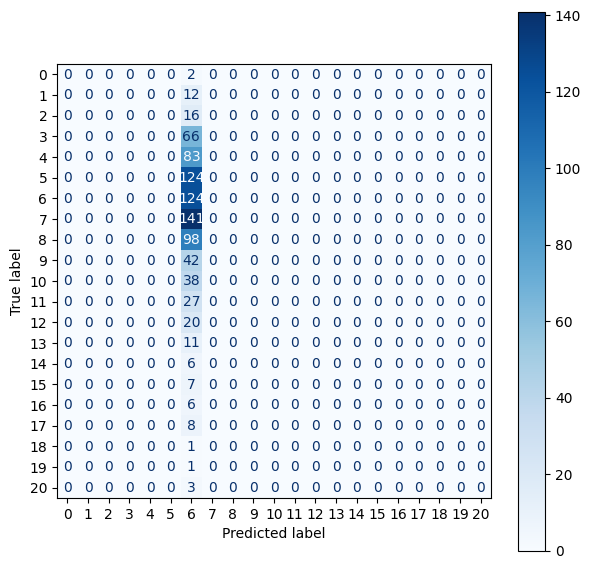

In [ ]:
# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(test_y,predict_y)
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figsize as needed
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()


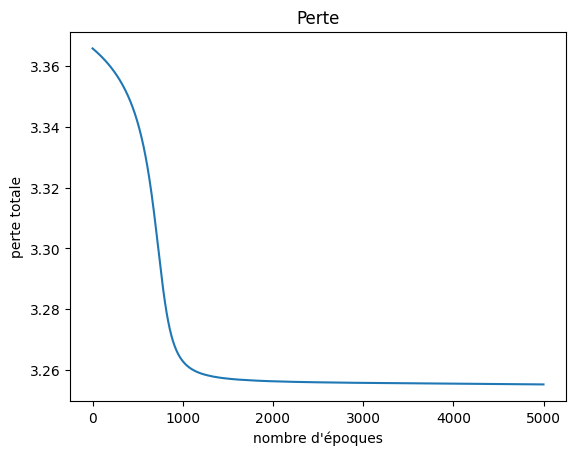

In [ ]:
plt.plot(loss)
plt.xlabel("nombre d'époques")
plt.ylabel("perte totale")
plt.title("Perte")
plt.show()